In [1]:
#### import necessary library
import numpy as np
from numpy.polynomial import hermite
from scipy.special import factorial, comb
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as la

from IPython.display import display, Latex
import copy

def make_hermitian(matrix):
  """
  Converts a given square matrix into a Hermitian matrix.

  Args:
    matrix: A NumPy array representing a square matrix (can be complex).

  Returns:
    A NumPy array representing the Hermitian version of the input matrix.
  """
  # Calculate the conjugate transpose (also known as Hermitian transpose)
  conjugate_transpose = matrix.conj().T
  
  # Calculate the Hermitian part: (A + A*)/2
  hermitian_matrix = (matrix + conjugate_transpose) / 2
  
  return hermitian_matrix

In [2]:
def degree(n : int)-> int:
    """
        Degree to list

    Args:
        n (int): The order of eigenstate.
    
    Returns:
        int: list of coefficient.
    n=0 -> [1]
    n=1 -> [0,1]
    n=2 -> [0,0,1]
    """
    arr = []
    i=0
    while i < n:
        arr.append(0)
        i += 1
    arr.append(1)
    return arr

def psi(x: float, n: int) -> float:
    """
    Harmonic oscillator wave function in position representation

    Args:
        n (int): The order of eigenstate.
        x (float, array): The position.
    
    Returns:
        float: The wave function.
    """
    N =  1./(np.sqrt(2**n*factorial(n))) * (1/np.pi)**(1/4) 
    return N * np.exp(-x**2/2) * hermite.hermval(x, degree(n)) 

def psi_k(k: float, n: int) -> float:
    """
    Harmonic oscillator wave function in position representation

    Args:
        n (int): The order of eigenstate.
        x (float, array): The position.
    
    Returns:
        float: The wave function.
    """
    N =  1./(np.sqrt(2**n*factorial(n))) * (1/np.pi)**(1/4) 
    return N * np.exp(-k**2/2) * hermite.hermval(k, degree(n)) * (-1j)**n

def energy(n):
    return n+0.5

def momentum_sqaure_psi(x,n):
    """
    Harmonic oscillator wave function in position representation

    Args:
        x (float, array): The position.
        n (int): The order of eigenstate.
    
    Returns:
        float: momentum squared time wave function.
    """
    N =  1./(np.sqrt(2**n*factorial(n))) * (1/np.pi)**(1/4)
    differentiated_1 = hermite.hermder(degree(n), m=1)
    differentiated_2 = hermite.hermder(degree(n), m=2)
    p2_psi = -N * np.exp(-x**2/2) * (hermite.hermval(x, differentiated_2) - 2*x*hermite.hermval(x, differentiated_1) + (x**2-1)*hermite.hermval(x, degree(n)))
    return p2_psi

In [3]:
### transform set of basis
def list_to_fock(x):
    fock_list = []
    x = np.array(x)
    N = np.max(x)+1

    for i in range(len(x)):
        fock = []
        for j in range(N):
            fock.append(np.count_nonzero(x[i]==j))
        fock_list.append(fock)
    return fock_list

def fock_to_energy(x):
    E_list = []
    x = np.array(x)
    N = len(x[0])

    for i in range(len(x)):
        E_ = 0
        for j in range(N):
            E_ += x[i][j] * E(j)
        E_list.append(E_)

    return E_list

def E(k):
    e = 0.5
    i = 0
    ### harmonic
    while i < k:
        e += 1
        i += 1
    ### anharmonic
    # while i < k:
    #     e += (4./5) ** i
    #     i += 1
    return e


# state = [2,0,2,1]
# list_to_fock(state)

In [4]:
#list_basis
N = 3
EnergyMax = 15
state = [0]*N
Index = N-1
list_basis = []
list_basis.append(list(state))


#generate bosonic fock basis via cut-off maximum energy
while Index >= 0:
    state[Index] = state[Index] + 1
    for i in range(Index, N):
        state[i] = state[Index]
    
    Energy = 0
    for j in range(0,N):
        Energy += E(state[j])

    if Energy <= EnergyMax:
        list_basis.append(list(state))
        Index = N-1
    else:
        Index-=1


### now define the act of operator
def a(i: int, fock_basis):
    if fock_basis[i] < 0:
        ein_val = 0
    else:
        ein_val = np.sqrt(fock_basis[i])
    fock_basis[i] = fock_basis[i]-1
    return [ein_val, fock_basis]

def ad(i: int, fock_basis):
    if fock_basis[i]+1 < 0:
        ein_val = 0
    else:
        ein_val = np.sqrt(fock_basis[i]+1)
    fock_basis[i] = fock_basis[i]+1
    return [ein_val, fock_basis]

def num_op(i: int, fock_basis):
    ein_val = fock_basis[i]
    return [ein_val, fock_basis]

# x = list(fock_basis[0])
# print(x)
# print(a(0,x))

# x = list(fock_basis[0])
# print(ad(0,x))

In [5]:
F = list_to_fock(list_basis)

### first we diagonalize H_0 using Harmonic basis to obtain non-interacting energy
psi_momentum_sqaure_psi = lambda x,n,m: psi(x,n) * momentum_sqaure_psi(x,m)
psi_position_sqaure_psi = lambda x,n,m: psi(x,n) * x**2 * psi(x,m)

def h_nm(n, m):
    h_p = quad(psi_momentum_sqaure_psi, -np.inf, np.inf, args=(n,m))[0]
    h_x = quad(psi_position_sqaure_psi, -np.inf, np.inf, args=(n,m))[0]
    return (h_p+h_x)/2

### check correct energy
M = len(F[0])
hij = np.zeros((M,M))
#print("{:.3f}".format(h_nm(i,j))) 
for i in range(M):
    for j in range(i,M):
        h = h_nm(i,j)
        if h<1e-10:
            hij[i][j] = 0
        else:
         hij[i][j] = h

hij = make_hermitian(np.array(hij))

nonzero_ind = np.transpose(np.nonzero(hij))

H = np.zeros((len(F),len(F)))
for k in range(len(F)):
    e_list = []
    for i in nonzero_ind:
        ein_a, F[k] = a(i[0], F[k])
        ein_ad, F[k]= ad(i[1], F[k])
        element = hij[i[0],i[1]] *  ein_ad * ein_a
        
        if F[k] in F:
            ind = F.index(F[k])
            H[ind,k] += element 
H = make_hermitian(H)
len(F)

123

In [6]:
### with H_int
u_func = lambda x,i,j,k,l: psi(x,i) * psi(x,j) * psi(x,k) * psi(x,l)

def Uijkl(i,j,k,l):
    r = quad(u_func, -np.inf, np.inf, args=(i,j,k,l))[0]
    return r

U = np.zeros((M,M,M,M))
for i in range(M):
    for j in range(M):
        for k in range(M):
            for l in range(M):
                if np.mod(i+j+k+l,2) == 1:
                    continue
                elif U[i,j,k,l]!=0:
                    continue
                else:
                    U[i,j,k,l] = Uijkl(i,j,k,l)
                    U[j,i,k,l] = U[i,j,k,l]
                    U[i,j,l,k] = U[i,j,k,l]
                    U[j,i,l,k] = U[i,j,k,l]
                    U[k,l,i,j] = U[i,j,k,l]



In [7]:
g_list = np.arange(0,20)

In [8]:
def spectrum(g, U, H):
    g = g
    U = g/2 * np.array(U)

    int = np.zeros((len(F),len(F)))
    nonzero_ind = np.transpose(np.nonzero(U))
    Hint = np.zeros((len(F),len(F)))
    for k in range(len(F)):
        e_list = []
        for i in nonzero_ind:
            Fs = copy.deepcopy(F[k])
            #print('b', Fs)
            ein_al, Fs = a(i[3], Fs)
            ein_ak, Fs = a(i[2], Fs)
            ein_adj, Fs= ad(i[1], Fs)
            ein_adi, Fs= ad(i[0], Fs)
            element = U[i[0],i[1],i[2],i[3]] *  ein_adi * ein_adj * ein_ak * ein_al
            #print('a', Fs, i, element)
            if Fs in F:
                #print('p', Fs)
                ind = F.index(Fs)
                Hint[ind,k] += element 

    Hint = make_hermitian(Hint)
    eigenvalues, eigenvectors = la.eig(H+Hint)
    idx = eigenvalues.argsort()
    eigenValues = eigenvalues[idx]
    return eigenValues 

In [9]:
s_list = []
for g in g_list:
    s_list.append(spectrum(g, U, H))


/Users/wirawatkokaew/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wirawatkokaew/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


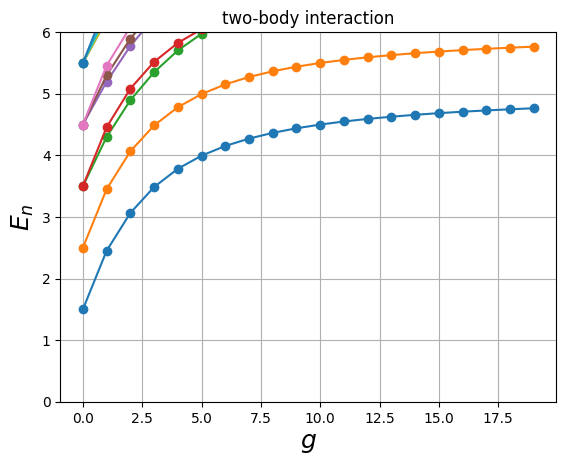

In [10]:
plt.plot(s_list,'o-')
plt.title('two-body interaction')
plt.ylim(0,6)
plt.ylabel('$E_n$', size = 18)
plt.xlabel('$g$', size = 18)
plt.grid()
plt.show()